<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_2_train_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 7: Generative Adversarial Networks**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 7 Material

* Part 7.1: Introduction to GANs for Image and Data Generation [[Video]](https://www.youtube.com/watch?v=hZw-AjbdN5k&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_1_gan_intro.ipynb)
* **Part 7.2: Train StyleGAN3 with your Own Images** [[Video]](https://www.youtube.com/watch?v=R546LYsQk5M&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_2_train_gan.ipynb)
* Part 7.3: Exploring the StyleGAN Latent Vector [[Video]](https://www.youtube.com/watch?v=goQzp8QSb2s&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_3_latent_vector.ipynb)
* Part 7.4: GANs to Enhance Old Photographs Deoldify [[Video]](https://www.youtube.com/watch?v=0OTd5GlHRx4&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_4_deoldify.ipynb)
* Part 7.5: GANs for Tabular Synthetic Data Generation [[Video]](https://www.youtube.com/watch?v=yujdA46HKwA&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_5_tabular_synthetic.ipynb)


# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [ ]:

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
!pip uninstall tensorflow
!pip install tensorflow

Found existing installation: tensorflow 2.9.2
Uninstalling tensorflow-2.9.2:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.9.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.9.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 17 kB/s 
     |████████████████████████████████| 438 kB 62.6 MB/s 
     |████████████████████████████████| 5.9 MB 43.5 MB/s 
     |████████████████████████████████| 1.7 MB 52.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
 

# Part 7.2: Train StyleGAN3 with your Images

Training GANs with StyleGAN is resource-intensive. The NVIDA StyleGAN researchers used computers with eight high-end GPUs for the high-resolution face GANs trained by NVIDIA. The GPU used by NVIDIA is an A100, which has more memory and cores than the P100 or V100 offered by even Colab Pro+. In this part, we will use StyleGAN2 to train rather than StyleGAN3. You can use networks trained with StyleGAN2 from StyleGAN3; however, StyleGAN3 usually is more effective at training than StyleGAN2.

Unfortunately, StyleGAN3 is compute-intensive and will perform slowly on any GPU that is not the latest Ampere technology. Because Colab does not provide such technology, I am keeping the training guide at the StyleGAN2 level. Switching to StyleGAN3 is relatively easy, as will be pointed out later. 

Make sure that you are running this notebook with a GPU runtime. You can train GANs with either Google Colab Free or Pro. I recommend at least the Pro version due to better GPU instances, longer runtimes, and timeouts. Additionally, the capability of Google Colab Pro to run in the background is valuable when training GANs, as you can close your browser or reboot your laptop while training continues.



You will store your training data and trained neural networks to GDRIVE. For GANs, I lay out my GDRIVE like this:

* ./data/gan/images - RAW images I wish to train on.
* ./data/gan/datasets - Actual training datasets that I convert from the raw images.
* ./data/gan/experiments - The output from StyleGAN2, my image previews, and saved network snapshots.

You will mount the drive at the following location.

```
/content/drive/MyDrive/data
```

## What Sort of GPU do you Have?

The type of GPU assigned to you by Colab will significantly affect your training time. Some sample times that I achieved with Colab are given here. I've found that Colab Pro generally starts you with a V100, however, if you run scripts non-stop for 24hrs straight for a few days in a row, you will generally be throttled back to a P100.

* 1024x1024 - V100 - 566 sec/tick (CoLab Pro)
* 1024x1024 - P100 - 1819 sec/tick (CoLab Pro)
* 1024x1024 - T4 - 2188 sec/tick (CoLab Free)

By comparison, a 1024x1024 GAN trained with StyleGAN3 on a V100 is 3087 sec/tick.

If you use Google CoLab Pro, generally, it will not disconnect before 24 hours, even if you (but not your script) are inactive. Free CoLab WILL disconnect a perfectly good running script if you do not interact for a few hours. The following describes how to circumvent this issue.

* [How to prevent Google Colab from disconnecting?](https://stackoverflow.com/questions/57113226/how-to-prevent-google-colab-from-disconnecting)

## Set Up New Environment

You will likely need to train for >24 hours. Colab will disconnect you. You must be prepared to restart training when this eventually happens. Training is divided into ticks, every so many ticks (50 by default), your neural network is evaluated, and a snapshot is saved. When CoLab shuts down, all training after the last snapshot is lost. It might seem desirable to snapshot after each tick; however, this snapshotting process itself takes nearly an hour. Learning an optimal snapshot size for your resolution and training data is important.

We will mount GDRIVE so that you will save your snapshots there. You must also place your training images in GDRIVE.

You must also install NVIDIA StyleGAN2 ADA PyTorch. We also need to downgrade PyTorch to a version that supports StyleGAN.

In [ ]:
!pip install torch==1.8.1 torchvision==0.9.1
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 804.1 MB 2.4 kB/s 
     |████████████████████████████████| 17.4 MB 48.0 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.8.1 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.8.1 which is incompatible.
Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating o

## Find Your Files

The drive is mounted to the following location.

```
/content/drive/MyDrive/data
```

It might be helpful to use an ```ls``` command to establish the exact path for your images.

In [ ]:
!ls /content/drive/MyDrive/data/gan/dataset/circuit/00000

img00000000.png  img00000105.png  img00000210.png  img00000315.png
img00000001.png  img00000106.png  img00000211.png  img00000316.png
img00000002.png  img00000107.png  img00000212.png  img00000317.png
img00000003.png  img00000108.png  img00000213.png  img00000318.png
img00000004.png  img00000109.png  img00000214.png  img00000319.png
img00000005.png  img00000110.png  img00000215.png  img00000320.png
img00000006.png  img00000111.png  img00000216.png  img00000321.png
img00000007.png  img00000112.png  img00000217.png  img00000322.png
img00000008.png  img00000113.png  img00000218.png  img00000323.png
img00000009.png  img00000114.png  img00000219.png  img00000324.png
img00000010.png  img00000115.png  img00000220.png  img00000325.png
img00000011.png  img00000116.png  img00000221.png  img00000326.png
img00000012.png  img00000117.png  img00000222.png  img00000327.png
img00000013.png  img00000118.png  img00000223.png  img00000328.png
img00000014.png  img00000119.png  img00000224.png  img00000329

## Convert Your Images

You must convert your images into a data set form that PyTorch can directly utilize. The following command converts your images and writes the resulting data set to another directory.

In [ ]:
CMD = "python /content/stylegan2-ada-pytorch/dataset_tool.py "\
  "--source /content/drive/MyDrive/data/gan/dataset/circuit/00000 "\
  "--dest /content/drive/MyDrive/data/gan/dataset/circuit"

!{CMD}

Error: --dest folder must be empty


You can use the following command to clear out the newly created dataset.  If something goes wrong and you need to clean up your images and rerun the above command, you should delete your partially completed dataset directory.

In [ ]:
#!rm -R /content/drive/MyDrive/data/gan/dataset/circuit/*

## Clean Up your Images

All images must have the same dimensions and color depth.  This code can identify images that have issues.

In [ ]:
from os import listdir
from os.path import isfile, join
import os
from PIL import Image
from tqdm.notebook import tqdm

IMAGE_PATH = '/content/drive/MyDrive/data/gan/dataset/circuit/00000'
files = [f for f in listdir(IMAGE_PATH) if isfile(join(IMAGE_PATH, f))]

base_size = None
for file in tqdm(files):
  file2 = os.path.join(IMAGE_PATH,file)
  img = Image.open(file2)
  sz = img.size
  if base_size and sz!=base_size:
    print(f"Inconsistant size: {file2}")
  elif img.mode!='RGB':
    print(f"Inconsistant color format: {file2}")
  else:
    base_size = sz


  0%|          | 0/418 [00:00<?, ?it/s]

## Perform Initial Training

This code performs the initial training.  Set SNAP low enough to get a snapshot before Colab forces you to quit.

In [ ]:
import os

# Modify these to suit your needs
EXPERIMENTS = "/content/drive/MyDrive/data/gan/experiments"
DATA = "/content/drive/MyDrive/data/gan/dataset/circuit/00000"
SNAP = 10

# Build the command and run it
cmd = f"/usr/bin/python3 /content/stylegan2-ada-pytorch/train.py "\
  f"--snap {SNAP} --outdir {EXPERIMENTS} --data {DATA}"
!{cmd}


Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 10,
  "network_snapshot_ticks": 10,
  "metrics": [
    "fid50k_full"
  ],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/content/drive/MyDrive/data/gan/dataset/circuit/00000",
    "use_labels": false,
    "max_size": 418,
    "xflip": false,
    "resolution": 1024
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 32768,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base":

## Resume Training

You can now resume training after you are interrupted by something in the pervious step.

In [ ]:
import os

# Modify these to suit your needs
EXPERIMENTS = "/content/drive/MyDrive/data/gan/experiments"
NETWORK = "network-snapshot-000000.pkl"
RESUME = os.path.join(EXPERIMENTS, \
                "00008-circuit-auto1-resumecustom", NETWORK)
DATA = "/content/drive/MyDrive/data/gan/dataset/circuit"
SNAP = 10

# Build the command and run it
cmd = f"/usr/bin/python3 /content/stylegan2-ada-pytorch/train.py "\
  f"--snap {SNAP} --resume {RESUME} --outdir {EXPERIMENTS} --data {DATA}"
!{cmd}


Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 10,
  "network_snapshot_ticks": 10,
  "metrics": [
    "fid50k_full"
  ],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/content/drive/MyDrive/data/gan/dataset/circuit",
    "use_labels": false,
    "max_size": 418,
    "xflip": false,
    "resolution": 1024
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 32768,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 32768

In [ ]:
!git clone https://github.com/NVlabs/stylegan3.git
!pip install ninja

Cloning into 'stylegan3'...
remote: Enumerating objects: 207, done.
remote: Total 207 (delta 0), reused 0 (delta 0), pack-reused 207
Receiving objects: 100% (207/207), 4.17 MiB | 18.89 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!ls /content/stylegan3

avg_spectra.py	 Dockerfile	  gen_video.py	metrics      train.py
calc_metrics.py  docs		  gui_utils	README.md    visualizer.py
dataset_tool.py  environment.yml  legacy.py	torch_utils  viz
dnnlib		 gen_images.py	  LICENSE.txt	training


In [ ]:
# HIDE OUTPUT
URL = "/content/drive/MyDrive/data/gan/experiments/00010-circuit-auto1-resumecustom/network-snapshot-000040.pkl"

!python /content/stylegan3/gen_images.py \
    --network={URL} \
  --outdir=/content/results --seeds=6600-6625 

Loading networks from "/content/drive/MyDrive/data/gan/experiments/00010-circuit-auto1-resumecustom/network-snapshot-000040.pkl"...
Generating image for seed 6600 (0/26) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generating image for seed 6601 (1/26) ...
Generating image for seed 6602 (2/26) ...
Generating image for seed 6603 (3/26) ...
Generating image for seed 6604 (4/26) ...
Generating image for seed 6605 (5/26) ...
Generating image for seed 6606 (6/26) ...
Generating image for seed 6607 (7/26) ...
Generating image for seed 6608 (8/26) ...
Generating image for seed 6609 (9/26) ...
Generating image for seed 6610 (10/26) ...
Generating image for seed 6611 (11/26) ...
Generating image for seed 6612 (12/26) ...
Generating image for seed 6613 (13/26) ...
Generating image for seed 6614 (14/26) ...
Generating image for seed 6615 (15/26) ...
Generating image for seed 6616 (16/26) ...
Generating image for seed 6617 (17/26) .

In [ ]:
!ls /content/results

seed6600.png  seed6606.png  seed6612.png  seed6618.png	seed6624.png
seed6601.png  seed6607.png  seed6613.png  seed6619.png	seed6625.png
seed6602.png  seed6608.png  seed6614.png  seed6620.png
seed6603.png  seed6609.png  seed6615.png  seed6621.png
seed6604.png  seed6610.png  seed6616.png  seed6622.png
seed6605.png  seed6611.png  seed6617.png  seed6623.png


In [ ]:
!cp /content/results/* \
    /content/drive/MyDrive/kirby_results

cp: target '/content/drive/MyDrive/kirby_results' is not a directory


In [ ]:
import sys
sys.path.insert(0, "/content/stylegan3")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, 
         nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    # [minibatch, height, width, channel]
    images = G.run(z, label, **G_kwargs) 
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail("Must specify class label with --class when using "\
            "a conditional network")
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ("warn: --class=lbl ignored when running on "\
            "an unconditional network")
  return label

def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', 
                   class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(\
      torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [ ]:
#URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/"\
#  "download/1.0.0/fish-gan-2020-12-09.pkl"
#URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/"\
#  "download/v1/christmas-gan-2020-12-03.pkl"
URL = "/content/drive/MyDrive/data/gan/experiments/00010-circuit-auto1-resumecustom/network-snapshot-000040.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "/content/drive/MyDrive/data/gan/experiments/00010-circuit-auto1-resumecustom/network-snapshot-000040.pkl"...


Seed 1000
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


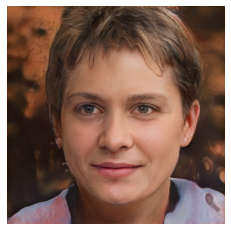

Seed 1001


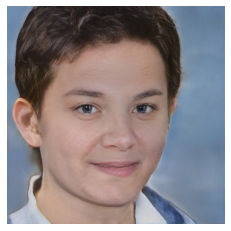

Seed 1002


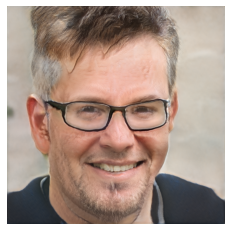

Seed 1003


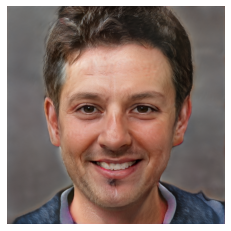

Seed 1004


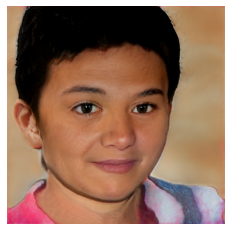

In [ ]:
# Choose your own starting and ending seed.
SEED_FROM = 1000
SEED_TO = 1005

# Generate the images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)

In [ ]:
def expand_seed(seeds, vector_size):
  result = []

  for seed in seeds:
    rnd = np.random.RandomState(seed)
    result.append( rnd.randn(1, vector_size) ) 
  return result

#URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/"\
#  "download/1.0.0/fish-gan-2020-12-09.pkl"
#URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/"\
#  "download/v1/christmas-gan-2020-12-03.pkl"
#URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"
URL = "/content/drive/MyDrive/data/gan/experiments/00010-circuit-auto1-resumecustom/network-snapshot-000040.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

vector_size = G.z_dim
# range(8192,8300)
seeds = expand_seed( [8192+1,8192+9], vector_size)
#generate_images(Gs, seeds,truncation_psi=0.5)
print(seeds[0].shape)

Loading networks from "/content/drive/MyDrive/data/gan/experiments/00010-circuit-auto1-resumecustom/network-snapshot-000040.pkl"...
(1, 512)


In [ ]:
# HIDE OUTPUT
# Choose your seeds to morph through and the number of steps to 
# take to get to each.

#SEEDS = [6624,6618,6616] # Better for faces
SEEDS = [1000,1003,1001] # Better for fish
STEPS = 100

# Remove any prior results
!rm /content/results/* 

from tqdm.notebook import tqdm

os.makedirs("./results/", exist_ok=True)

# Generate the images for the video.
idx = 0
for i in range(len(SEEDS)-1):
  v1 = seed2vec(G, SEEDS[i])
  v2 = seed2vec(G, SEEDS[i+1])

  diff = v2 - v1
  step = diff / STEPS
  current = v1.copy()

  for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
    current = current + step
    img = generate_image(device, G, current)
    img.save(f'./results/frame-{idx}.png')
    idx+=1
 
# Link the images into a video.
!ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y movie.mp4


Seed 1000:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 1003:   0%|          | 0/100 [00:00<?, ?it/s]

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

In [ ]:
from google.colab import files
files.download('movie.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>